Aim: 
- Define best (and second best) stage-damage function for survey dataset to use them as baseline for the multivariat models
- Evaluate functions by MSE, R2 etc

In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt

from scipy import stats, optimize
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline


In [29]:
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_coords.xlsx")

df_candidates = gpd.GeoDataFrame(df_candidates, crs="EPSG:4326", geometry=gpd.points_from_xy(df_candidates.lat, df_candidates.lon))
df_candidates.tail(2)

,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_business,shp_damage_level_products,shp_closed_d,shp_duration_back2normal,contaminations,...,elevation_building_height_cm,building_elevation_rel2surrounding,building_elevation_rel2surrounding.cm,shp_sector.specify,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_monetary_resources_prenvention,lat,lon,geometry
502,2.0,70.0,2.0,10,0.0,4,2,2,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
503,0.0,100.0,5.0,20,0.0,1,1,14,20,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY


In [30]:
## remove businesses without direct damage costs

df_candidates.Target_direct.value_counts();
df_candidates = df_candidates[df_candidates.Target_direct > 0.0]  # 136=0.0
print(df_candidates.shape)


(216, 29)


### univariate regressions (linear, square root, expo)


In [97]:
df_candidates = df_candidates[['water_depth_cm', 'inundation_duration_h', 'contaminations', 'Target_direct']].dropna()
df_candidates = df_candidates.sort_values(by='water_depth_cm')

y = df_candidates.Target_direct.astype("float64")
X_unscaled = df_candidates['water_depth_cm'].values.astype("float64")


#### Normalize independend variables 
- due that they dont have a gaussian distribution, donwside is that distance to outliers is decreased so outliers have influence on the loss calculation (smaller standard deviations when using normaization)


In [102]:
scaler = MinMaxScaler() 
X = scaler.fit_transform(X_unscaled.reshape(-1, 1))


In [103]:
## linear and root reg without least square method
def linear_func(x,m,c):
    return m*x + c
## Alternative: Linear least squares regression - incluedes already evaluation params
#linear_reg = stats.linregress(X, y)


# Schoppa et al 2020 used square root regression
def root_func(x,m,c):
    return m*np.sqrt(x) + c


def exp_func(x,m,c):
    #p_1st = np.polyfit(X, y, 1)  # linear func, np.log(y) in combi wtih weights
    #m = np.exp(p_1st[1]) # p_1st[1] = slope ? , polynomial back to exponential
    b = -0.5 # initally guessed,  # p_1st[0] 
    return m * np.exp(b * x) + c
#x_fitted = np.linspace(np.min(X), np.max(X), 100) # Create the fitted curve
#y_fitted = m * np.exp(b * x_fitted)  # Create the fitted curve


def standard_deviation(covariance):
    """
    code: https://www.mandeepbasson.com/resources/python/curvefitting/curve_fitting/
    """
    return np.sqrt(np.diag(covariance))



## Loss functions , precictor= water depth

In [106]:
## Fit regression functions

params, pcov = optimize.curve_fit(linear_func, X.flatten(), y)
params_root, pcov_root = optimize.curve_fit(root_func, X.flatten(), y)
params_exp, pcov_exp = optimize.curve_fit(exp_func, X.flatten(), y)
# print(f"optimized params for exponential func: slope: {params_exp[0]}, b: {params_exp[1]}")#, intercept{params_exp[2]}")

print(f"R-squared, linear reg: {r2_score(y, linear_func(X, *params)):.2f}")#{linear_reg.rvalue**2:.3f}")
print(f"R-squared, root reg: {r2_score(y, root_func(X, *params_root)):.2f}")
print(f"R-squared, exponential reg: {r2_score( y, exp_func(X, *params_exp)):.2f}")

# print(f'The equation of the line of best fit is y = {m2:.2f}*x^0.5 + {c2:.2f}')

R-squared, linear reg: 0.05
R-squared, root reg: 0.04
R-squared, exponential reg: 0.05


### Plot water depth vs Target

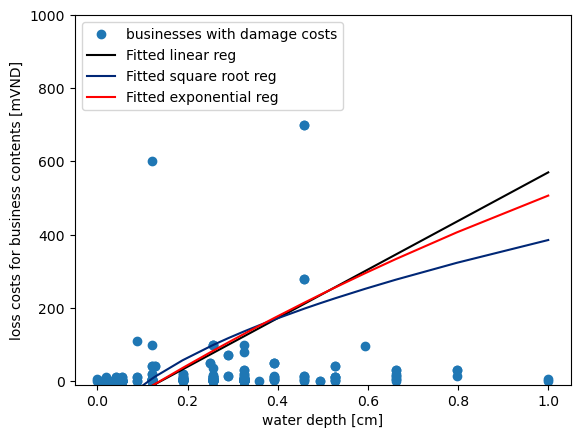

In [107]:
plt.plot(X, y, 'o', label='businesses with damage costs')
plt.plot(X, linear_func(X, *params), 'black', label='Fitted linear reg')
plt.plot(X, root_func(X, *params_root), '#002776', label='Fitted square root reg')
plt.plot(X, exp_func(X, *params_exp), 'r', label='Fitted exponential reg')
#plt.plot(x_fitted, y_fitted, 'r', label='Fitted exponential reg')

plt.ylim(-10,1000)
plt.xlabel("water depth [cm]")
plt.ylabel("loss costs for business contents [mVND]")
plt.legend()

# plt.plot(X.water_depth_cm, y, 'o', label='original data')
# # linear fnc
# plt.plot(X.water_depth_cm, linear_reg.intercept + linear_reg.slope * X.water_depth_cm, 'r', label='fitted linear reg')
#plt.plot(X.water_depth_cm, linear_func(X.water_depth_cm, *params), 'r-')
#         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

## ## Loss functions , predictor= inundation duration

In [110]:
df_candidates = df_candidates.sort_values(by='inundation_duration_h')

y = df_candidates.Target_direct.astype("float64")
X_unscaled = df_candidates['inundation_duration_h'].values.astype("float64")

scaler = MinMaxScaler() 
X = scaler.fit_transform(X_unscaled.reshape(-1,1))
 

In [114]:
params, pcov = optimize.curve_fit(linear_func, X.flatten(), y)
params_root, pcov_root = optimize.curve_fit(root_func, X.flatten(), y)
params_exp, pcov_exp = optimize.curve_fit(exp_func, X.flatten(), y)

#linear_reg = stats.linregress(X, y)
print(f"R-squared, linear reg: {r2_score( y, linear_func(X, *params)):.5f}")
print(f"R-squared, root reg: {r2_score( y, root_func(X, *params_root)):.5f}")
print(f"R-squared, exponential reg: {r2_score( y, exp_func(X, *params_exp)):.5f}")

R-squared, linear reg: 0.00603
R-squared, root reg: 0.02464
R-squared, exponential reg: 0.00853


### Plot inundation duration vs Target

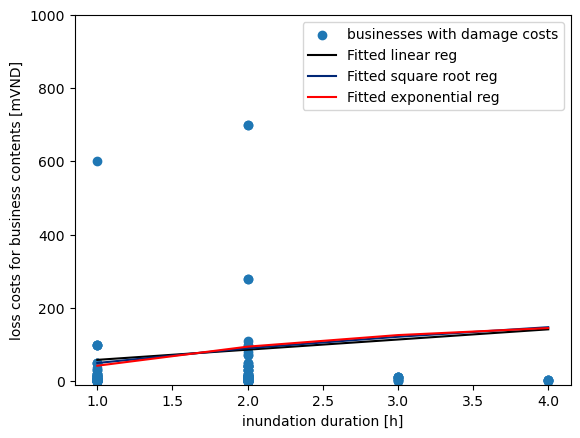

In [13]:
plt.scatter(X, y, label='businesses with damage costs')
#plt.plot(X, y, 'o', label='businesses with damage costs')
plt.plot(X, linear_func(X, *params), 'black', label='Fitted linear reg')
plt.plot(X, root_func(X, *params_root), '#002776', label='Fitted square root reg')
plt.plot(X, exp_func(X, *params_exp) ,'r', label='Fitted exponential reg')

plt.ylim(-10,1000)
plt.xlabel("inundation duration [h]")
plt.ylabel("loss costs for business contents [mVND]")
plt.legend()


## bivariate regressions (linear, square root, expo)


In [116]:
df_candidates = df_candidates.sort_values(by=['water_depth_cm','inundation_duration_h'])

X_unscaled = df_candidates[['water_depth_cm', 'inundation_duration_h']].values
y = df_candidates['Target_direct'].values

scaler = MinMaxScaler() 
X = scaler.fit_transform(X_unscaled)


In [117]:
def linear_bifunc(x,a,b,c):
    return a*x[0] + b*x[1] + c
# Alternative:
    # linReg = LinearRegression()
    # linReg.fit(x, y)
    # y_pred = linReg.predict(x)
        
def root_bifunc(x,a,b,c):
    return a*np.sqrt(x[0]) + b*np.sqrt(x[1]) + c


def exp_bifunc(x,a,b,d):
    d = 0.5 # initally guessed,  # p_1st[0] 
    return a*np.exp(d*x[0]) + b*np.exp(d*x[1]) # + c  # TODO why decreases r2 if y-intercept is added?

# p = np.polyfit(X, np.log(y), 1) # Fit linear function - polynomial=1
# m = np.exp(p[1]) # Convert the polynomial back into an exponential
# b = p[0]
# x_fitted = np.linspace(np.min(X), np.max(X), 100) # Create the fitted curve
# y_fitted = m * np.exp(b * x_fitted)  # Create the fitted curve



In [146]:
# linReg = LinearRegression()
# linReg.fit(X, y)
# y_pred = linReg.predict(X)

#r2_score( y, linear_bifunc(XX, *params))

(216, 4)

### LS fitting bivariate functions

Code snippets_ https://enjoymachinelearning.com/blog/multivariate-polynomial-regression-python/

In [127]:
## Fit bivariate regression functions

XX = X.reshape( X.shape[1], X.shape[0])  # reshape neeeded for curve_fit()

params, pcov = optimize.curve_fit(linear_bifunc, XX.flatten(),  list(y))
params_root, pcov_root = optimize.curve_fit(root_bifunc, XX.flatten(),  list(y))
params_exp, pcov_exp = optimize.curve_fit(exp_bifunc, XX.flatten(),  list(y))
print(f"optimized params for exponential func: slope: {params_exp[0]}, b: {params_exp[1]}, intercept={params_exp[2]}")#, intercept{params_exp[2]}")


def r2_adjusted(X, y, y_pred):
    """
    calc based on number of variabels adjusted R2
    """
    r2 = r2_score(y, y_pred)
    try:
        r2_adj = 1 - (1-r2) * (len(y) - 1) / (len(y) - X.shape[0] -1) # nbr of variabels are now stored XX.shape[0] 
        return r2_adj
    except:
        return r2


def mse(y, y_pred):
    return mean_squared_error(y, y_pred)

def rmse(y, y_pred):
    return mean_squared_error(y, y_pred, squared=False)


print(f"Linear regression : \n  adjusted R2: {r2_adjusted(XX.flatten(), y, linear_bifunc(XX, *params)):.3f}",
      f"\n  MSE: {mse(y, linear_bifunc(XX, *params)):.3f}",
      f"\n  RMSE : {rmse(y, linear_bifunc(XX, *params)):.3f}\n"
      )
print(f"Root regression : \n  adjusted R2: {r2_adjusted(XX, y, linear_bifunc(XX, *params_root)):.3f}",
      f"  \n  MSE: {mse(y, linear_bifunc(XX, *params_root)):.3f}",
      f"  \n  RMSE : {rmse(y, linear_bifunc(XX, *params_root)):.3f}\n"
      )
print(f"Exponential regression : \n  adjusted R2: {r2_adjusted(XX, y, exp_bifunc(XX, *params_exp)):.3f}",
      f"  \n  MSE: {mse(y, exp_bifunc(XX, *params_exp)):.3f}",
      f"  \n  RMSE : {rmse(y, exp_bifunc(XX, *params_exp)):.3f}\n"
      )


# func_names = ["linear regression", "root regression", "exponential regression"]
# for i,func in enumerate([linear_bifunc(XX, *params), root_bifunc(XX, *params_root), exp_bifunc(XX, *params_exp)]):
#     print(f" {func_names[i]}  : \nadjusted R2: {r2_score_using_multivariate(XX, y, func):.3f}",
#       f"\nMSE: {mean_squared_error(y, func):.3f}",
#       f"\nRMSE : {root_mean_squared_error(y, func):.3f}"
#     )



optimized params for exponential func: slope: 246.98628140687362, b: -167.64277468575392, intercept=1.0
Linear regression : 
  adjusted R2: 53.711 
  MSE: 17800603.501 
  RMSE : 4219.076

Root regression : 
  adjusted R2: -0.556   
  MSE: 515803.877   
  RMSE : 718.195

Exponential regression : 
  adjusted R2: -0.017   
  MSE: 337075.375   
  RMSE : 580.582



## Summary

- with combinec targets the bivariate functions perform quite similar worse as with univarite regressions
  - i.e. water depth and indundation duration explain nearly nothing of the variance in direct loss costs for business contents 
- also wit both target used seperatly, the univarite and bivariate regressions are still similar inappriate
- this leads to underlines the assumption of the highly influence of multiple variables, which was aleady observed in the pearso nCorrelation Coefficients 

####################################

### reste
- plot MSE
- get acc for each degree, -  example uses polynomials

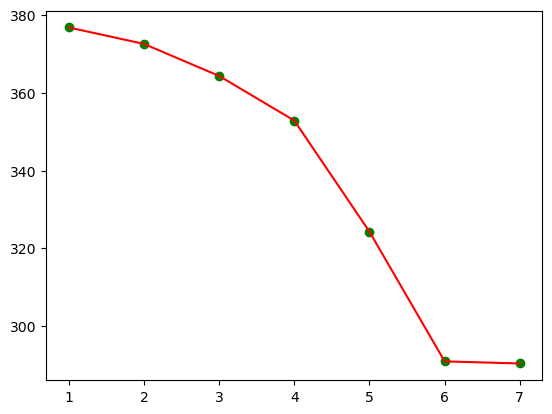

In [147]:
# # check  accuracy for each degree, the lower the error the better!
# number_degrees = [1,2,3,4,5,6,7]
# plt_mean_squared_error = []

# X = df_candidates[['water_depth_cm', 'inundation_duration_h']].values#, # univariate: best with 4 polynomial

# for degree in number_degrees:

#    poly_model = PolynomialFeatures(degree=degree)
  
#    poly_x_values = poly_model.fit_transform(X)
#    poly_model.fit(poly_x_values, y)
  
#    regression_model = LinearRegression()
#    regression_model.fit(poly_x_values, y)
#    y_pred = regression_model.predict(poly_x_values)
  
#    plt_mean_squared_error.append(mean_squared_error(y, y_pred, squared=False))
  
# plt.scatter(number_degrees, plt_mean_squared_error, color="green")
# plt.plot(number_degrees, plt_mean_squared_error, color="red") 